This notebook fills the NaN values of isochrones, routes, poi features with nearest neighbour values due to time constraints.

In [75]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Initialize Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Rental Data Imputation") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark version: {spark.version}")
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Spark version: 4.0.1
Spark UI available at: http://192.168.1.46:4040


In [ ]:
import pandas as pd
import geopandas as gpd
from ..utils.preprocess import PreprocessUtils
from shapely import wkt

# Initialize the preprocessor
preprocessor = PreprocessUtils()

# ORS (Open Route Service) PTV Routes

In [77]:
# read in everything we obtained thus far which is in data/processed/routes/ptv/routes_ptv_combined.csv 

routes_ptv = pd.read_csv("../data/processed/routes/ptv/routes_ptv_combined.csv")

# lower case column names and snake case
routes_ptv.columns = routes_ptv.columns.str.lower().str.replace(" ", "_")

# drop the rows where Station_ID is NaN
routes_ptv = routes_ptv[routes_ptv["stationid"].notna()]

# drop the rows where Station_ID is 0
routes_ptv = routes_ptv[routes_ptv["stationid"] != 0]

# drop coordinates column from routes_ptv to prepare for merge
routes_ptv = routes_ptv.drop(columns=["coordinates"])



In [78]:
routes_ptv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5760 entries, 0 to 11491
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_id       5760 non-null   int64  
 1   stationid         5760 non-null   object 
 2   min_route_dist_m  5760 non-null   float64
 3   min_route_dur_s   5760 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 225.0+ KB


Note: these routes were calculated on the previous sampled dataset before we fixed the wayback coordinate order issue. We also have to stack the results from `data/processed/routes/`. 

In [79]:
merged_routes = preprocessor.merge_batches("../data/processed/routes", verbose=True)
# lower cast column names and snake case
merged_routes.columns = merged_routes.columns.str.lower().str.replace(" ", "_")

routes_ptv = pd.concat([routes_ptv, merged_routes])

# drop duplicates by property_id keep first
routes_ptv = routes_ptv.drop_duplicates(subset="property_id", keep="first")

# drop coordinates column from routes_ptv
routes_ptv = routes_ptv.drop(columns=["coordinates"])



Starting merge process...
Input directory: ../data/processed/routes
File pattern: *.csv
------------------------------------------------------------
Found 18 files to merge:
  - batch_0001_with_routes.csv
  - batch_0002_with_routes.csv
  - batch_0003_with_routes.csv
  - batch_0004_with_routes.csv
  - batch_0005_with_routes.csv
  - batch_0006_with_routes.csv
  - batch_0007_with_routes.csv
  - batch_0008_with_routes.csv
  - batch_0009_with_routes.csv
  - batch_0010_with_routes.csv
  - batch_0011_with_routes.csv
  - batch_0012_with_routes.csv
  - batch_0013_with_routes.csv
  - batch_0014_with_routes.csv
  - batch_0015_with_routes.csv
  - batch_0016_with_routes.csv
  - batch_0017_with_routes.csv
  - batch_0018_with_routes.csv

  Loaded: batch_0001_with_routes.csv (500 rows)
  Loaded: batch_0002_with_routes.csv (500 rows)
  Loaded: batch_0003_with_routes.csv (500 rows)
  Loaded: batch_0004_with_routes.csv (500 rows)
  Loaded: batch_0005_with_routes.csv (500 rows)
  Loaded: batch_0006_with_r

In [80]:
routes_ptv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14760 entries, 0 to 8999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_id       14760 non-null  int64  
 1   stationid         14701 non-null  object 
 2   min_route_dist_m  14701 non-null  float64
 3   min_route_dur_s   14701 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 576.6+ KB


In [81]:
# read in cleaned_listings_sampled.csv which is in data/processed/domain/cleaned_listings_sampled.csv

cleaned_listings_sampled = pd.read_csv("../data/processed/domain/cleaned_listings_sampled.csv")
# convert property_id to int64
cleaned_listings_sampled["property_id"] = cleaned_listings_sampled["property_id"].astype("Int64")

# Convert string coordinates to actual geometry objects
cleaned_listings_sampled["coordinates"] = cleaned_listings_sampled["coordinates"].apply(wkt.loads)

# Convert to GeoDataFrame
cleaned_listings_sampled = gpd.GeoDataFrame(cleaned_listings_sampled, geometry="coordinates")

# merge cleaned_listings_sampled with routes_ptv on property_id
cleaned_listings_sampled = cleaned_listings_sampled.merge(routes_ptv, on="property_id", how="left")

# rename stationid to closest_ptv_station_id
cleaned_listings_sampled = cleaned_listings_sampled.rename(columns={"stationid": "closest_ptv_station_id"})

cleaned_listings_sampled.info()



<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13101 entries, 0 to 13100
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   property_id             13101 non-null  Int64   
 1   rental_price            13101 non-null  float64 
 2   bedrooms                13101 non-null  int64   
 3   bathrooms               13101 non-null  int64   
 4   car_spaces              13101 non-null  int64   
 5   property_type           13101 non-null  object  
 6   suburb                  13101 non-null  object  
 7   year                    13101 non-null  int64   
 8   quarter                 13101 non-null  int64   
 9   longitude               13101 non-null  float64 
 10  latitude                13101 non-null  float64 
 11  coordinates             13101 non-null  geometry
 12  closest_ptv_station_id  11709 non-null  object  
 13  min_route_dist_m        11709 non-null  float64 
 14  min_route_dur_

In [82]:
missing_routes = cleaned_listings_sampled[cleaned_listings_sampled["closest_ptv_station_id"].isnull()][['property_id', 'coordinates']]

In [83]:
batch_size = 500
output_dir = "../data/raw/missing_routes"
preprocessor.split_into_batches(missing_routes, batch_size, output_dir)

Saved batch_0001.csv: 500 rows
Saved batch_0002.csv: 500 rows
Saved batch_0003.csv: 392 rows

Total batches created: 3
Output directory: ../data/raw/missing_routes


['../data/raw/missing_routes/batch_0001.csv',
 '../data/raw/missing_routes/batch_0002.csv',
 '../data/raw/missing_routes/batch_0003.csv']

In [84]:
# impute by nearest neighbour
cleaned_listings_sampled['closest_ptv_station_id_imputed'] = preprocessor.impute_by_nearest_point(cleaned_listings_sampled, 'closest_ptv_station_id')
cleaned_listings_sampled['min_route_dist_m_imputed'] = preprocessor.impute_by_nearest_point(cleaned_listings_sampled, 'min_route_dist_m')
cleaned_listings_sampled['min_route_dur_s_imputed'] = preprocessor.impute_by_nearest_point(cleaned_listings_sampled, 'min_route_dur_s')



Imputing null values in 1 column(s): ['closest_ptv_station_id']
Total rows with null values to impute: 1392
Successfully imputed: 1392 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_route_dist_m']
Total rows with null values to impute: 1392
Successfully imputed: 1392 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_route_dur_s']
Total rows with null values to impute: 1392
Successfully imputed: 1392 rows, Could not impute (no data available): 0


In [85]:
cleaned_listings_sampled.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13101 entries, 0 to 13100
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   property_id                     13101 non-null  Int64   
 1   rental_price                    13101 non-null  float64 
 2   bedrooms                        13101 non-null  int64   
 3   bathrooms                       13101 non-null  int64   
 4   car_spaces                      13101 non-null  int64   
 5   property_type                   13101 non-null  object  
 6   suburb                          13101 non-null  object  
 7   year                            13101 non-null  int64   
 8   quarter                         13101 non-null  int64   
 9   longitude                       13101 non-null  float64 
 10  latitude                        13101 non-null  float64 
 11  coordinates                     13101 non-null  geometry
 12  closest_pt

# OSM (Open Street Map) POI

In [86]:
# read in poi_features_combined.csv which is in data/processed/poi_features/poi_features_combined.csv
poi_features = pd.read_csv("../data/processed/poi_features/poi_features_combined_before_imputation.csv")

# converrt column name of PropertyID to property_id
poi_features = poi_features.rename(columns={"PropertyID": "property_id"})


In [87]:
# read in poi_features for wayback
poi_features_wayback = preprocessor.merge_batches("../data/processed/poi_features_wayback", verbose=True) 
# rename column name of PropertyID to property_id
poi_features_wayback = poi_features_wayback.rename(columns={"PropertyID": "property_id"})

# stack poi_features_wayback and poi_features
poi_features = pd.concat([poi_features, poi_features_wayback])

# drop duplicates by property_id keep first
poi_features = poi_features.drop_duplicates(subset="property_id", keep="first")


Starting merge process...
Input directory: ../data/processed/poi_features_wayback
File pattern: *.csv
------------------------------------------------------------
Found 13 files to merge:
  - poi_features_0001.csv
  - poi_features_0002.csv
  - poi_features_0003.csv
  - poi_features_0004.csv
  - poi_features_0005.csv
  - poi_features_0006.csv
  - poi_features_0007.csv
  - poi_features_0008.csv
  - poi_features_0009.csv
  - poi_features_0010.csv
  - poi_features_0011.csv
  - poi_features_0012.csv
  - poi_features_0013.csv

  Loaded: poi_features_0001.csv (500 rows)
  Loaded: poi_features_0002.csv (500 rows)
  Loaded: poi_features_0003.csv (500 rows)
  Loaded: poi_features_0004.csv (500 rows)
  Loaded: poi_features_0005.csv (500 rows)
  Loaded: poi_features_0006.csv (500 rows)
  Loaded: poi_features_0007.csv (500 rows)
  Loaded: poi_features_0008.csv (500 rows)
  Loaded: poi_features_0009.csv (500 rows)
  Loaded: poi_features_0010.csv (500 rows)
  Loaded: poi_features_0011.csv (500 rows)


In [88]:
# show null value information
poi_features.isnull().sum()



property_id                                 0
count_atm                                4541
count_bank                               3353
count_childcare                          4083
count_clinic                             2948
count_community_centre                   2917
count_doctors                            3583
count_fast_food                          1155
count_fuel                               1027
count_kindergarten                       2177
count_parking_space                      3391
count_restaurant                         1613
min_dist_atm                             4541
min_dist_bank                            3353
min_dist_childcare                       4083
min_dist_clinic                          2948
min_dist_community_centre                2917
min_dist_doctors                         3583
min_dist_fast_food                       1155
min_dist_fuel                            1027
min_dist_kindergarten                    2177
min_dist_parking_space            

In [89]:
# merge poi_features with cleaned_listings_sampled on property_id
cleaned_listings_sampled = cleaned_listings_sampled.merge(poi_features, on="property_id", how="left")

# show null value information
cleaned_listings_sampled.isnull().sum()

property_id                                 0
rental_price                                0
bedrooms                                    0
bathrooms                                   0
car_spaces                                  0
property_type                               0
suburb                                      0
year                                        0
quarter                                     0
longitude                                   0
latitude                                    0
coordinates                                 0
closest_ptv_station_id                   1392
min_route_dist_m                         1392
min_route_dur_s                          1392
closest_ptv_station_id_imputed              0
min_route_dist_m_imputed                    0
min_route_dur_s_imputed                     0
count_atm                                7626
count_bank                               6627
count_childcare                          7376
count_clinic                      

In [90]:
# get the column names of cleaned_listings_sampled with null values
columns_with_na = list(cleaned_listings_sampled.columns[cleaned_listings_sampled.isnull().any()])


In [91]:
# amongst the columns_with_na, pick the columns that start with count_
count_cols = [col for col in columns_with_na if col.startswith("count_")]

# fill these count_cols with 0 and rename the column name with _imputed
cleaned_listings_sampled[count_cols] = cleaned_listings_sampled[count_cols].fillna(0)
cleaned_listings_sampled = cleaned_listings_sampled.rename(columns={col: col+"_imputed" for col in count_cols})

# order columns alphabetically
cleaned_listings_sampled = cleaned_listings_sampled.reindex(sorted(cleaned_listings_sampled.columns), axis=1)


In [92]:
# show null value information
cleaned_listings_sampled.isnull().sum()

bathrooms                                        0
bedrooms                                         0
car_spaces                                       0
closest_ptv_station_id                        1392
closest_ptv_station_id_imputed                   0
coordinates                                      0
count_atm_imputed                                0
count_bank_imputed                               0
count_bar_imputed                                0
count_biergarten_imputed                         0
count_brothel_imputed                            0
count_bus_station;shelter_imputed                0
count_bus_station_imputed                        0
count_cafe;bar_imputed                           0
count_cafe;deli_imputed                          0
count_cafe_imputed                               0
count_car_rental_imputed                         0
count_car_wash;cafe_imputed                      0
count_casino_imputed                             0
count_charging_station_imputed 

In [93]:
# update the column names of cleaned_listings_sampled with null values
columns_with_na = list(cleaned_listings_sampled.columns[cleaned_listings_sampled.isnull().any()])

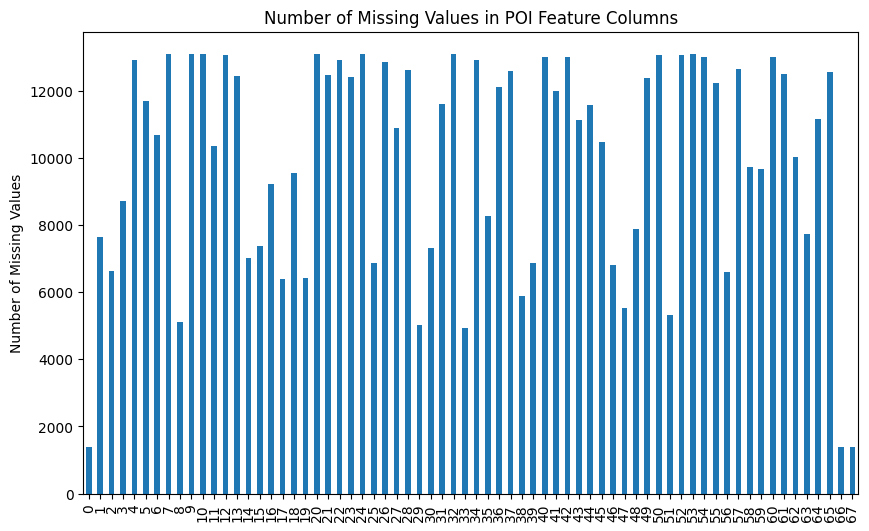

In [94]:
# create a barchart of the number of missing values in each column of columns_with_na

# use matplotlib to create a barchart of the number of missing values in each column of columns_with_na
plt.figure(figsize=(10, 6))
cleaned_listings_sampled[columns_with_na].isnull().sum().plot(kind="bar")

# use numbers for the xticks labels
plt.xticks(range(len(columns_with_na)), range(len(columns_with_na)))
# rotate the xticks labels by 90 degrees
plt.xticks(rotation=90)
# set the y-axis label to "Number of Missing Values"
plt.ylabel("Number of Missing Values")
plt.title("Number of Missing Values in POI Feature Columns")

plt.show()



In [95]:
for col in columns_with_na:
    cleaned_listings_sampled[col+"_imputed"] = preprocessor.impute_by_nearest_point(cleaned_listings_sampled, col)

# Verify that all null values have been imputed
print("\nNull values remaining:")
print(cleaned_listings_sampled[columns_with_na].isnull().sum())



Imputing null values in 1 column(s): ['closest_ptv_station_id']
Total rows with null values to impute: 1392
Successfully imputed: 1392 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_atm']
Total rows with null values to impute: 7626
Successfully imputed: 7626 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_bank']
Total rows with null values to impute: 6627
Successfully imputed: 6627 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_bar']
Total rows with null values to impute: 8707
Successfully imputed: 8707 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_biergarten']
Total rows with null values to impute: 12913
Successfully imputed: 12913 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_brothel']
Total rows with null values to impute: 11692
Successfully imputed: 

# ORS Isochrones

In [96]:
# read in driving_isochrones_wayback 
driving_isochrones_wayback = preprocessor.merge_batches("../data/processed/isochrones/wayback/driving", verbose=True)
# drop the coordinates column from driving_isochrones_wayback
driving_isochrones_wayback = driving_isochrones_wayback.drop(columns=["coordinates"])
# change the column names of 5min, 10min, 15min to driving_5min, driving_10min, driving_15min
driving_isochrones_wayback.rename(columns={"5min": "driving_5min", "10min": "driving_10min", "15min": "driving_15min"}, inplace=True)

# read in walking_isochrones_wayback
walking_isochrones_wayback = preprocessor.merge_batches("../data/processed/isochrones/wayback/walking", verbose=True)
# drop the coordinates column from walking_isochrones_wayback
walking_isochrones_wayback = walking_isochrones_wayback.drop(columns=["coordinates"])
# change the column names of 5min, 10min, 15min to walking_5min, walking_10min, walking_15min
walking_isochrones_wayback.rename(columns={"5min": "walking_5min", "10min": "walking_10min", "15min": "walking_15min"}, inplace=True)

# merge the driving_isochrones_wayback and walking_isochrones_wayback on property_id
isochrones_wayback = pd.merge(driving_isochrones_wayback, walking_isochrones_wayback, on="property_id", how="outer")


Starting merge process...
Input directory: ../data/processed/isochrones/wayback/driving
File pattern: *.csv
------------------------------------------------------------
Found 13 files to merge:
  - isochrone_0001.csv
  - isochrone_0002.csv
  - isochrone_0003.csv
  - isochrone_0004.csv
  - isochrone_0005.csv
  - isochrone_0006.csv
  - isochrone_0007.csv
  - isochrone_0008.csv
  - isochrone_0009.csv
  - isochrone_0010.csv
  - isochrone_0011.csv
  - isochrone_0012.csv
  - isochrone_0013.csv

  Loaded: isochrone_0001.csv (500 rows)
  Loaded: isochrone_0002.csv (500 rows)
  Loaded: isochrone_0003.csv (500 rows)
  Loaded: isochrone_0004.csv (500 rows)
  Loaded: isochrone_0005.csv (500 rows)
  Loaded: isochrone_0006.csv (500 rows)
  Loaded: isochrone_0007.csv (500 rows)
  Loaded: isochrone_0008.csv (500 rows)
  Loaded: isochrone_0009.csv (500 rows)
  Loaded: isochrone_0010.csv (500 rows)
  Loaded: isochrone_0011.csv (500 rows)
  Loaded: isochrone_0012.csv (500 rows)
  Loaded: isochrone_0013.c

In [97]:
isochrones_wayback.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   driving_5min   4929 non-null   object 
 1   driving_10min  4929 non-null   object 
 2   driving_15min  4929 non-null   object 
 3   property_id    6499 non-null   float64
 4   walking_5min   5629 non-null   object 
 5   walking_10min  5629 non-null   object 
 6   walking_15min  5629 non-null   object 
dtypes: float64(1), object(6)
memory usage: 355.5+ KB


In [98]:
live_listings = pd.read_csv("../data/processed/domain/live_listings.csv")

# Convert string coordinates to actual geometry objects
live_listings["coordinates"] = live_listings["coordinates"].apply(wkt.loads)

# Convert to GeoDataFrame
live_listings = gpd.GeoDataFrame(live_listings, geometry="coordinates")

live_listings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12649 entries, 0 to 12648
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   property_id         12649 non-null  float64 
 1   rental_price        12649 non-null  float64 
 2   suburb              12649 non-null  object  
 3   postcode            12649 non-null  int64   
 4   property_type       12649 non-null  object  
 5   year                12649 non-null  int64   
 6   quarter             12649 non-null  int64   
 7   bedrooms            12649 non-null  int64   
 8   bathrooms           12649 non-null  int64   
 9   car_spaces          12649 non-null  int64   
 10  age_0_to_19         12649 non-null  float64 
 11  age_20_to_39        12649 non-null  float64 
 12  age_40_to_59        12649 non-null  float64 
 13  age_60_plus         12649 non-null  float64 
 14  agency_name         12649 non-null  object  
 15  appointment_only    12649 no

In [99]:
# read in isochrones_combined.csv which is in data/processed/isochrones/isochrones_combined.csv
isochrones_driving = pd.read_csv("../data/processed/isochrones/driving/isochrones_driving_combined.csv")
# rename 5min, 10min, 15min to driving_5min, driving_10min, driving_15min   
isochrones_driving.rename(columns={"5min": "driving_5min", "10min": "driving_10min", "15min": "driving_15min"}, inplace=True)
# drop the coordinates column from isochrones_driving
isochrones_driving = isochrones_driving.drop(columns=["coordinates"])

isochrones_walking = pd.read_csv("../data/processed/isochrones/walking/isochrones_walking_combined.csv")
# rename 5min, 10min, 15min to walking_5min, walking_10min, walking_15min
isochrones_walking.rename(columns={"5min": "walking_5min", "10min": "walking_10min", "15min": "walking_15min"}, inplace=True)
# drop the coordinates column from isochrones_walking
isochrones_walking = isochrones_walking.drop(columns=["coordinates"])

# merge isochrones_driving and isochrones_walking on property_id
isochrones_live = pd.merge(isochrones_driving, isochrones_walking, on="property_id", how="outer")

# select only rows where property_id is in live_listings
isochrones_live = isochrones_live[isochrones_live["property_id"].isin(live_listings["property_id"])]

isochrones_live.info()




<class 'pandas.core.frame.DataFrame'>
Index: 15005 entries, 2 to 34913
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   driving_5min   13863 non-null  object 
 1   driving_10min  13863 non-null  object 
 2   driving_15min  13863 non-null  object 
 3   property_id    15005 non-null  float64
 4   walking_5min   9695 non-null   object 
 5   walking_10min  9695 non-null   object 
 6   walking_15min  9695 non-null   object 
dtypes: float64(1), object(6)
memory usage: 937.8+ KB


In [100]:
# stack isochrones_live and isochrones_wayback using concat
isochrones = pd.concat([isochrones_live, isochrones_wayback])

isochrones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21504 entries, 2 to 6498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   driving_5min   18792 non-null  object 
 1   driving_10min  18792 non-null  object 
 2   driving_15min  18792 non-null  object 
 3   property_id    21504 non-null  float64
 4   walking_5min   15324 non-null  object 
 5   walking_10min  15324 non-null  object 
 6   walking_15min  15324 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.3+ MB


In [101]:
# merge live_listings with isochrones_combined on property_id
cleaned_listings_sampled = cleaned_listings_sampled.merge(isochrones, on="property_id", how="left")

# impute the isochrones with the nearest neighbour values
cleaned_listings_sampled[['driving_5min_imputed', 'driving_10min_imputed', 'driving_15min_imputed']] = preprocessor.impute_by_nearest_point(cleaned_listings_sampled, ['driving_5min', 'driving_10min', 'driving_15min'])
cleaned_listings_sampled[['walking_5min_imputed', 'walking_10min_imputed', 'walking_15min_imputed']] = preprocessor.impute_by_nearest_point(cleaned_listings_sampled, ['walking_5min', 'walking_10min', 'walking_15min'])

cleaned_listings_sampled.info()




Imputing null values in 3 column(s): ['driving_5min', 'driving_10min', 'driving_15min']
Total rows with null values to impute: 2191
Successfully imputed: 2191 rows, Could not impute (no data available): 0
Imputing null values in 3 column(s): ['walking_5min', 'walking_10min', 'walking_15min']
Total rows with null values to impute: 3690
Successfully imputed: 3690 rows, Could not impute (no data available): 0
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14497 entries, 0 to 14496
Columns: 225 entries, bathrooms to walking_15min_imputed
dtypes: Int64(1), float64(202), geometry(1), int64(5), object(16)
memory usage: 24.9+ MB


In [102]:
# save final cleaned_listings_sampled to data/curated/rent_features/cleaned_listings_sampled.csv
cleaned_listings_sampled.to_csv("../data/curated/rent_features/cleaned_listings_sampled.csv", index=False)


In [103]:
# save cleaned_listings_sampled with pickle 
cleaned_listings_sampled.to_pickle("../data/curated/rent_features/cleaned_listings_sampled.pkl")

# Save as Parquet with Spark (ensuring files < 50MB)
print("\nSaving to Parquet format with Spark...")

# Convert geometry column to WKT string format (Parquet doesn't support geometry natively)
cleaned_listings_spark_df = cleaned_listings_sampled.copy()
cleaned_listings_spark_df['coordinates_wkt'] = cleaned_listings_spark_df['coordinates'].apply(lambda geom: geom.wkt)

# Drop the original geometry column and reset to regular DataFrame
cleaned_listings_spark_df = cleaned_listings_spark_df.drop(columns=['coordinates'])
cleaned_listings_spark_df = pd.DataFrame(cleaned_listings_spark_df)

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(cleaned_listings_spark_df)

# Estimate the number of partitions needed to keep files under 50MB
# Average row size in memory: 32MB / 14497 rows ≈ 2.2KB per row
# For parquet with snappy compression (typically 50-70% compression ratio)
# Target: ~40MB per file to have buffer, with 2.2KB/row * 0.6 compression ≈ 1.3KB/row
# Records per file: 40MB / 1.3KB ≈ 30,000 records
records_per_partition = 5000  # Conservative estimate to ensure < 50MB per file

num_partitions = max(1, (spark_df.count() + records_per_partition - 1) // records_per_partition)

print(f"Total records: {spark_df.count()}")
print(f"Creating {num_partitions} partitions")
print(f"Estimated records per file: ~{spark_df.count() // num_partitions}")

# Repartition and save
output_path = "../data/curated/rent_features/cleaned_listings_sampled_parquet"

spark_df.repartition(num_partitions) \
    .write \
    .mode("overwrite") \
    .option("compression", "snappy") \
    .option("maxRecordsPerFile", records_per_partition) \
    .parquet(output_path)

print(f"\nParquet files saved to: {output_path}")

# Verify file sizes
import os
parquet_files = [f for f in os.listdir(output_path) if f.endswith('.parquet')]
print(f"\nCreated {len(parquet_files)} parquet file(s):")
for f in sorted(parquet_files):
    size_mb = os.path.getsize(os.path.join(output_path, f)) / (1024 * 1024)
    print(f"  {f}: {size_mb:.2f} MB")


Saving to Parquet format with Spark...


/Users/jackshee/University/MAST30034 Applied Data Science/project2/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:425: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Expected bytes, got a 'float' object
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
25/10/12 18:17:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/10/12 18:17:40 WARN TaskSetManager: Stage 0 contains a task of very large size (13031 KiB). The maximum recommended task size is 1000 KiB.
25/10/12 18:17:47 WARN TaskSetManager: Stage 3 contains a task of very large size (13031 KiB). The maximum recommended task size is 1000 KiB.
25/10/12 18:17:50 WARN TaskSetManager: Stage 6 contains a task of very lar

Total records: 14497
Creating 3 partitions


Estimated records per file: ~4832


25/10/12 18:17:53 WARN TaskSetManager: Stage 9 contains a task of very large size (13031 KiB). The maximum recommended task size is 1000 KiB.



Parquet files saved to: ../data/curated/rent_features/cleaned_listings_sampled_parquet

Created 3 parquet file(s):
  part-00000-dbef74e3-d42a-4336-8a9c-60b571c37f2c-c000.snappy.parquet: 63.22 MB
  part-00001-dbef74e3-d42a-4336-8a9c-60b571c37f2c-c000.snappy.parquet: 62.26 MB
  part-00002-dbef74e3-d42a-4336-8a9c-60b571c37f2c-c000.snappy.parquet: 62.37 MB


In [104]:
# Example: How to read the parquet files back into a GeoDataFrame
# Uncomment to test reading:

# Read with Spark
spark_df_loaded = spark.read.parquet("../data/curated/rent_features/cleaned_listings_sampled_parquet")
df_loaded = spark_df_loaded.toPandas()

# Convert WKT back to geometry
from shapely import wkt
df_loaded['coordinates'] = df_loaded['coordinates_wkt'].apply(wkt.loads)
df_loaded = df_loaded.drop(columns=['coordinates_wkt'])

# Convert back to GeoDataFrame
gdf_loaded = gpd.GeoDataFrame(df_loaded, geometry='coordinates')
print(gdf_loaded.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14497 entries, 0 to 14496
Columns: 225 entries, bathrooms to coordinates
dtypes: float64(202), geometry(1), int64(6), object(16)
memory usage: 24.9+ MB
None


In [105]:
# sort columns alphabetically
gdf_loaded = gdf_loaded.reindex(sorted(gdf_loaded.columns), axis=1)

In [106]:
# print the number of missing values in each column
print(gdf_loaded.isnull().sum())




bathrooms                                           0
bedrooms                                            0
car_spaces                                          0
closest_ptv_station_id                              0
closest_ptv_station_id_imputed                      0
coordinates                                         0
count_atm_imputed                                   0
count_bank_imputed                                  0
count_bar_imputed                                   0
count_biergarten_imputed                            0
count_brothel_imputed                               0
count_bus_station;shelter_imputed                   0
count_bus_station_imputed                           0
count_cafe;bar_imputed                              0
count_cafe;deli_imputed                             0
count_cafe_imputed                                  0
count_car_rental_imputed                            0
count_car_wash;cafe_imputed                         0
count_casino_imputed        

In [112]:
type(gdf_loaded)

geopandas.geodataframe.GeoDataFrame

In [113]:
gdf_loaded['walking_5min_imputed'].isnull().sum()

np.int64(0)

In [115]:
gdf_loaded.shape

(14497, 225)

25/10/14 06:24:24 WARN TransportChannelHandler: Exception in connection from /192.168.1.46:50781
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:255)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:356)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:796)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimi

In [114]:
gdf_loaded['walking_5min_imputed']

0        POLYGON ((144.993977 -37.883742, 144.99466 -37...
1        POLYGON ((145.120851 -37.817673, 145.121167 -3...
2        POLYGON ((144.980151 -37.809144, 144.981467 -3...
3        POLYGON ((144.879025 -37.693274, 144.880107 -3...
4        POLYGON ((144.980067 -37.801878, 144.980199 -3...
5        POLYGON ((144.917833 -37.785707, 144.917978 -3...
6        POLYGON ((145.06007 -37.828482, 145.060175 -37...
7        POLYGON ((145.014365 -37.82033, 145.014497 -37...
8        POLYGON ((145.165101 -37.888951, 145.165094 -3...
9        POLYGON ((144.975185 -37.805791, 144.976402 -3...
10       POLYGON ((145.206825 -37.97882, 145.206613 -37...
11       POLYGON ((144.785639 -37.757341, 144.787794 -3...
12       POLYGON ((145.033404 -37.876289, 145.033356 -3...
13       POLYGON ((144.973048 -37.804186, 144.973162 -3...
14       POLYGON ((145.119514 -37.718139, 145.120862 -3...
15       POLYGON ((145.029008 -37.821325, 145.029064 -3...
16       POLYGON ((145.085715 -37.899429, 145.085748 -3.